## Import pakages

In [ ]:
#!pip install pyodbc
# import pyodbc

In [ ]:
# import packages

import pandas as pd
import sqlalchemy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Data Acquisition
Below are scripts I used to acquire the AS400 data via the ODBC driver. I have saved and uploaded the datasets to the folders for ease of use.

In [ ]:
# connect to the database
# cnxn = pyodbc.connect(driver = '{iSeries Access ODBC Driver}', system ='10.200.11.2', uid='YHSIEH',pwd = 'YHSIEH',LibraryList=['CONTAF','GUARDERIAF','REGALOF','PEDIDOSF','RETRIPLUSF','TRANSPORF','RTESF'])

In [ ]:
# create a cursor object
# c1 = cnxn.cursor()

*sql command in order to get data from the specified table
dataset1: Select data of clients that are currently active.* 

sql1 = "SELECT P.*, B.PBJFEC FROM \
PEDIDOSF.PAGADOR AS P, PEDIDOSF.PAGBAJ AS B \
WHERE (P.PAGCLI = B.PBJCLI) AND (P.PAGFEC LIKE '1%' OR P.PAGFEC LIKE '2%') AND P.PAGACT = 0 \
UNION ALL \
SELECT A.*, C.PBJFEC FROM \
GUARDERIAF.PAGADOR AS A, GUARDERIAF.PAGBAJ AS C \
WHERE (A.PAGCLI = C.PBJCLI) AND (A.PAGFEC LIKE '1%' OR A.PAGFEC LIKE '2%') AND A.PAGACT = 0 \
UNION ALL \
SELECT D.*, E.PBJFEC FROM \
REGALOF.PAGADOR AS D, REGALOF.PAGBAJ AS E \
WHERE (D.PAGCLI = E.PBJCLI) AND (D.PAGFEC LIKE '1%' OR D.PAGFEC LIKE '2%') AND D.PAGACT = 0 \
UNION ALL \
SELECT F.*, G.PBJFEC FROM \
RETRIPLUSF.PAGADOR AS F, RETRIPLUSF.PAGBAJ AS G \
WHERE (F.PAGCLI = G.PBJCLI) AND (F.PAGFEC LIKE '1%' OR F.PAGFEC LIKE '2%') AND F.PAGACT = 0 \
UNION ALL \
SELECT H.*, I.PBJFEC FROM \
TRANSPORF.PAGADOR AS H, TRANSPORF.PAGBAJ AS I \
WHERE (H.PAGCLI = I.PBJCLI) AND (H.PAGFEC LIKE '1%' OR H.PAGFEC LIKE '2%') AND H.PAGACT = 0 \
ORDER BY PAGFEC"

In [ ]:
# df_client = pd.read_sql(sql1,cnxn)

In [ ]:
# Save this df as csv so I can access and work on the dataset.
# df_client.to_csv(r"C:\Users\yhsieh\Documents\client.csv",sep=',')

 *define sql command in order to get data from the specified table
dataset2: Select sales data (all-time) but only with active clients.*

sql2 = "SELECT * \
FROM REGALOF.FACCAB AS R \
WHERE R.FACCLI IN (SELECT PAGCLI FROM REGALOF.PAGADOR WHERE PAGACT =0) \
UNION ALL \
SELECT * \
FROM GUARDERIAF.FACCAB AS G \
WHERE G.FACCLI IN (SELECT PAGCLI FROM GUARDERIAF.PAGADOR WHERE PAGACT =0) \
UNION ALL \
SELECT * \
FROM CONTAF.FACCAB AS C \
WHERE C.FACCLI IN (SELECT PAGCLI FROM PEDIDOSF.PAGADOR WHERE PAGACT =0) \
UNION ALL \
SELECT * \
FROM RETRIPLUSF.FACCAB AS E \
WHERE E.FACCLI IN (SELECT PAGCLI FROM RETRIPLUSF.PAGADOR WHERE PAGACT =0) \
UNION ALL \
SELECT * FROM TRANSPORF.TSFACCAB AS T \
WHERE T.FACCLI IN (SELECT PAGCLI FROM TRANSPORF.PAGADOR WHERE PAGACT =0) \
UNION ALL \
SELECT * FROM PEDIDOSF.TSFACCAB AS A \
WHERE A.FACCLI IN (SELECT PAGCLI FROM PEDIDOSF.PAGADOR WHERE PAGACT =0)"

In [ ]:
# df_sales = pd.read_sql(sql2,cnxn)

In [ ]:
# Save this df as csv so I can access and work on the dataset.
# df_sales.to_csv(r"C:\Users\yhsieh\Documents\sales.csv",sep=',')

Now that I have 2 datasets (Client dataset and Sales dataset). I can start doing the data exploritory analysis.

## Data Exploration

### Client Dataset Overview

In [ ]:
df_client = pd.read_csv('client.csv')

In [ ]:
# Have the first glance of the client dataset
df_client.head()

,Unnamed: 0,PAGACT,PAGCLI,PAGRZ1,PAGRZ2,PAGDI1,PAGDI2,PAGDP,PAGPOB,PAGPRO,PAGTEL,PAGFAX,PAGLOG,PAGMOD,PAGDIA,PAGGRU,PAGNNO,PAGFCA,PAGINT,PAGCON,PAGALB,PAGFAC,PAGDF1,PAGDF2,PAGDPF,PAGPOF,PAGPRF,PAGFEC,PAGCOM,PAGFIJ,PAGNPR,PAGTRA,PAGVEN,PAGCFA,PAGDEU,PAGCIF,PAGTE1,PAGTE2,PAGMOV,PAGPER,PBJFEC
0,0,0,1.0,"PUBLIESPAÑA, S.A.U.",,"CTRA. FUENCARRAL-ALCOBENDAS, 4",,28049,MADRID,MADRID,913959000,,0.0,2.0,0.0,1027.0,,0.0,,YOLANDA CERVIGÓN MARTÍN,1.0,51.0,"CTRA. FUENCARRAL-ALCOBENDAS, 4",,28049,MADRID,MADRID,19920324.0,0.50,2.0,,0.0,86.0,1.0,0.0,A78928371,Nº Cuenta: ES30 2100 3782 41 2200007548 ...,...,0.0,1.0,0.0
1,1,0,8.0,"ANTARES, S.A.",,"PLAZA DE LAS CORTES, 8",,28014,MADRID,MADRID,915236345,,0.0,2.0,10.0,1.0,,0.0,,LETICIA GONZÁLEZ/MARISOL SANCHEZ,1.0,10.0,"PLAZA DE LAS CORTES, 8",,28014,MADRID,MADRID,19920413.0,0.00,0.0,,5.0,86.0,8.0,0.0,A78586344,Nº Cuenta: ES30 2100 3782 41 2200007548 ...,...,0.0,98.0,0.0
2,2,0,16.0,ADIC,,CTRA.COLMENAR KM.14 UAM.,,28049,CANTOBLANCO,MADRID,"397,85,22",,0.0,1.0,0.0,99999.0,,0.0,,BEATRIZ,1.0,1.0,CTRA.COLMENAR KM.14 UAM.,,28049,CANTOBLANCO,MADRID,19920421.0,2.00,0.0,,0.0,86.0,16.0,0.0,G79251716,...,...,0.0,99.0,0.0
3,3,0,14.0,"EUROP ASSISTANCE ESPAÑA, S.A.",,"ORENSE, 4 PLTA. 10ª",,28020,MADRID,MADRID,915972125,,0.0,2.0,0.0,6.0,,0.0,,Mª ANGELES REGALADO GUTIERREZ,1.0,10.0,"ORENSE, 4 PLTA. 10ª",,28020,MADRID,MADRID,19920421.0,1.00,0.0,,0.0,44.0,14.0,0.0,A28461994,Nº Cuenta: ES30 2100 3782 41 2200007548 ...,Nº DE PEDIDO RC2021051 ...,0.0,98.0,0.0
4,4,0,32.0,"JOHNSON'S WAX ESPAÑOLA, S.L.",,QUINTANAVIDES 17 EDIF. 3 PLTA. 4,,28050,MADRID,MADRID,914565100,913940151,0.0,2.0,21.0,40.0,,0.0,,DPTO. CONTABLE,1.0,3.0,QUINTANAVIDES 17 ED.36 P.4,,28050,MADRID,MADRID,19920423.0,1.85,2.0,,5.0,99.0,32.0,0.0,B28128890,Nº DE PEDIDO ANUAL: 110077 ...,...,0.0,98.0,0.0


In [ ]:
# Identify column names and variables types
df_client.columns

Index(['Unnamed: 0', 'PAGACT', 'PAGCLI', 'PAGRZ1', 'PAGRZ2', 'PAGDI1',
       'PAGDI2', 'PAGDP', 'PAGPOB', 'PAGPRO', 'PAGTEL', 'PAGFAX', 'PAGLOG',
       'PAGMOD', 'PAGDIA', 'PAGGRU', 'PAGNNO', 'PAGFCA', 'PAGINT', 'PAGCON',
       'PAGALB', 'PAGFAC', 'PAGDF1', 'PAGDF2', 'PAGDPF', 'PAGPOF', 'PAGPRF',
       'PAGFEC', 'PAGCOM', 'PAGFIJ', 'PAGNPR', 'PAGTRA', 'PAGVEN', 'PAGCFA',
       'PAGDEU', 'PAGCIF', 'PAGTE1', 'PAGTE2', 'PAGMOV', 'PAGPER', 'PBJFEC'],
      dtype='object')

In [ ]:
df_client.shape

(7331, 41)

#### Variable Types
**Categorical variables:** 
- PAGACT: Active Status, should remove because this dataset only includes active clients.
- PAGCLI: Client code
- PAGRZ1: Client company name 1
- PAGRZ2: Client company name 2
- PAGDI1: Address 1, will remove and use Fiscal address.
- PAGDI2: Address 2, will remove and use Fiscal address.
- PAGDP: Postal code, will remove and use Fiscal address.
- PAGPOB: City, will remove and use Fiscal address.
- PAGPRO: Province, will remove and use Fiscal address.
- PAGTEL: Phone number, should remove because it doesn't add value.
- PAGFAX: Fax number, should remove because it doesn't add value.
- PAGGRU: Client Group code
- PAGNNO: N/A (Info not available)
- PAGFCA: N/A (Info not available)
- PAGINT: All blank, should remove because it doesn't add value.
- PAGCON: At.factura
- PAGALB: T.Albarán
- PAGFAC: T.factura
- PAGDF1: Fiscal address 1
- PAGDF2: Fiscal address 2
- PAGDPF: Fiscal postal code
- PAFPOF: Fiscal city
- PAGPRF: Fiscal province
- PAGNPR: N/A (Info not available)
- PAGVEN: Up Spain Comercial Code
- PAGCFA: Client Facturado (TBC)
- PAGCIF: Client CIF
- PAGTE1: Text on the Bill 1, should remove because it doesn't add value. 
- PAGTE2: Text on the Bill 2, should remove because it doesn't add value.
- PAGMOV: Mobile phone, should remove because it doesn't add value.
- PAGMOD: Payment Method
- PAGPER: Payment Freqency, one number corresponds to one category. (TBC if this column should be removed because it's not the reality, just an estimation.)
- PAGDIA: Payment Day of a month.

**Numerical variables:**
- PAGLOG: N/A (Info not available)
- PAGCOM: Commission
- PAGFIJ: Forfeit
- PAGTRA: Shipping Cost
- PAGDEU: Risk 

**DateTime variables:**
- PAGFEC: Client opt-in date (The date that a client signed the contract with Up Spain)
- PBJFEC: Unsubscribe date (The date that a client ended the contract). This column will be removed because in this analysis we only care about the active clients. (Those that haven't ended the contract with Up Spain.)

Now I'll remove the columns that are not of our interests:

In [ ]:
df_client_clean = df_client.drop(['PAGACT','Unnamed: 0','PAGRZ1','PAGRZ2','PAGDI1','PAGDI2','PAGDP','PAGPOB','PAGPRO','PAGTEL','PAGFAX','PAGINT','PAGCON','PAGDF1','PAGDF2','PAGDPF','PAGCFA','PAGTE1','PAGTE2','PAGMOV', 'PAGNPR','PAGFCA', 'PBJFEC'],axis=1)

In [ ]:
df_client_clean.columns

Index(['PAGCLI', 'PAGLOG', 'PAGMOD', 'PAGDIA', 'PAGGRU', 'PAGNNO', 'PAGALB',
       'PAGFAC', 'PAGPOF', 'PAGPRF', 'PAGFEC', 'PAGCOM', 'PAGFIJ', 'PAGTRA',
       'PAGVEN', 'PAGDEU', 'PAGCIF', 'PAGPER'],
      dtype='object')

#### Data Visualization

Numerical Variables:

In [ ]:
# Select columns that are of my interest:
var_num = ['PAGLOG','PAGCOM','PAGFIJ','PAGTRA','PAGDEU']

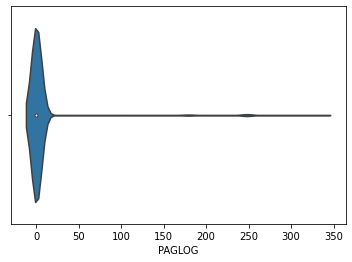

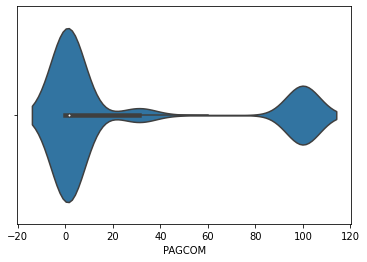

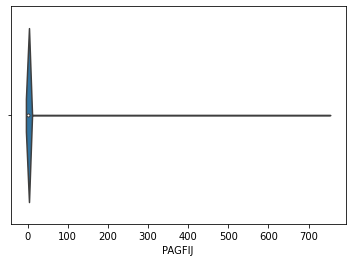

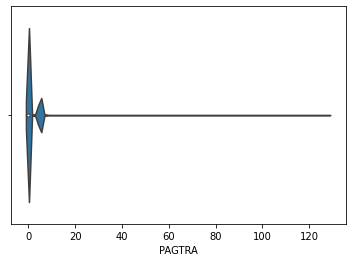

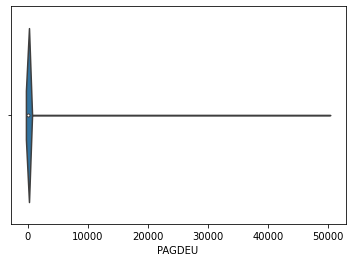

<Figure size 432x288 with 0 Axes>

In [ ]:
for var in var_num:
  sns.violinplot(x=df_client_clean[var]) 
  plt.figure()

In [ ]:
for var in var_num:
  df_valuecounts = pd.DataFrame(df_client_clean[var].value_counts())
  df_valuecounts['percentage'] = pd.DataFrame(df_client_clean[var].value_counts()/df_client_clean[var].count())
  print(df_valuecounts.head(10))

       PAGLOG  percentage
0.0      7104    0.969036
248.0      65    0.008866
179.0      24    0.003274
183.0       7    0.000955
163.0       5    0.000682
151.0       5    0.000682
184.0       4    0.000546
253.0       3    0.000409
252.0       3    0.000409
233.0       3    0.000409
       PAGCOM  percentage
0.00     2164    0.295185
99.95    1472    0.200791
1.00      576    0.078570
1.50      482    0.065748
30.95     399    0.054426
0.50      329    0.044878
2.00      235    0.032056
2.50      218    0.029737
99.94     120    0.016369
99.93     108    0.014732
        PAGFIJ  percentage
0.00      4339    0.591870
2.00      2946    0.401855
50.00        7    0.000955
75.00        5    0.000682
41.67        5    0.000682
100.00       2    0.000273
90.00        2    0.000273
150.00       2    0.000273
200.00       2    0.000273
66.66        2    0.000273
       PAGTRA  percentage
0.00     5562    0.758696
5.00     1444    0.196972
6.00      191    0.026054
4.00       63    0.008594
8

From both the graphs and the output of the above for-loop, I can conclude that except the Commission column, the other variables' values are very focused on 1-2 primary values.

As for PAGCOM (commissions), Up Spain has 2 types of commissions:

1.   Fixed Commissions: Some clients have a fixed commission %. This commission % doesn't change no matter which sales amount they order.
2.   Commissions based on Sales: Different commission % are applied based on the sales amount a client orders. The commission values that are above 30% in the commission column belong to this type of commissions. These commission values should be categorized or transformed. Because when it shows 99.93 it doesn´t really mean 99.93% commission applied.



Categorical Variables

In [ ]:
# Select columns that are of my interest:
var_car = df_client_clean.drop(var_num,axis=1).drop(['PAGFEC','PAGCLI','PAGGRU','PAGCIF'],axis=1).columns
var_car

Index(['PAGMOD', 'PAGDIA', 'PAGNNO', 'PAGALB', 'PAGFAC', 'PAGPOF', 'PAGPRF',
       'PAGVEN', 'PAGPER'],
      dtype='object')

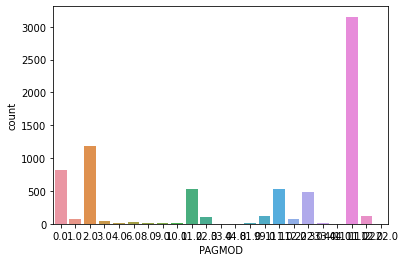

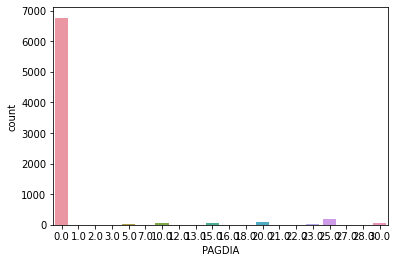

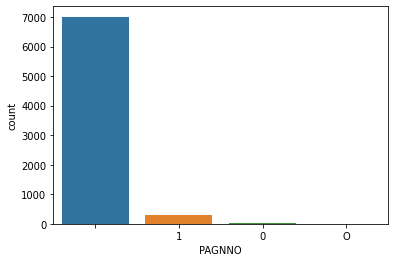

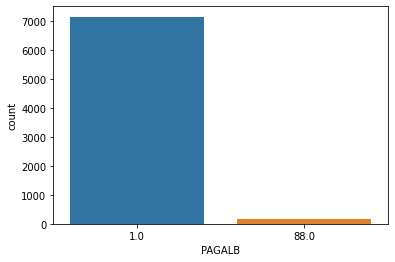

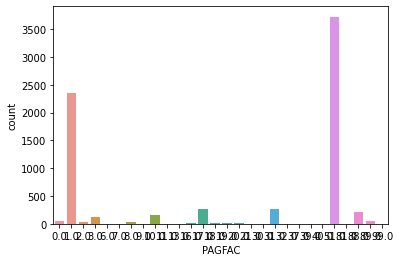

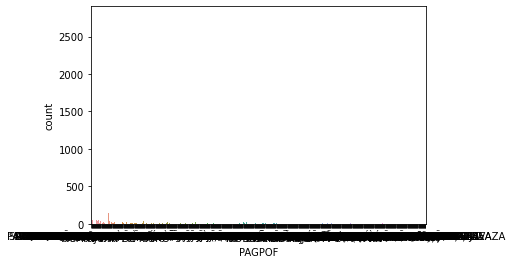

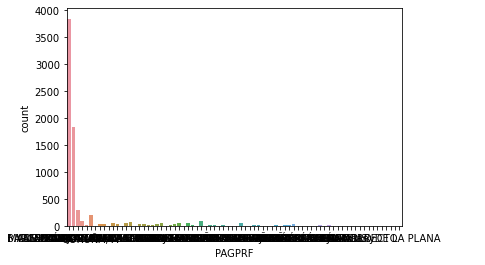

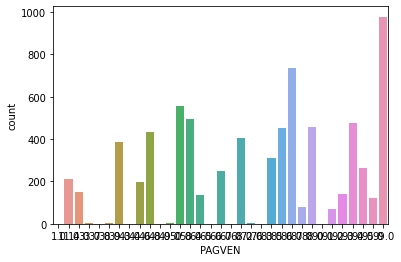

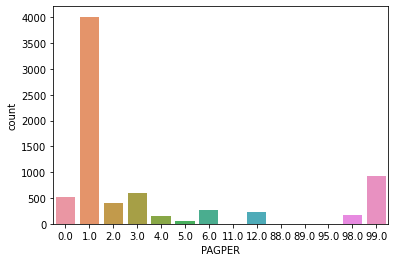

<Figure size 432x288 with 0 Axes>

In [ ]:
for var in var_car:
  sns.countplot(x=df_client_clean[var]) 
  plt.figure()

In [ ]:
for var in var_car:
  df_valuecounts = pd.DataFrame(df_client_clean[var].value_counts())
  df_valuecounts['percentage'] = pd.DataFrame(df_client_clean[var].value_counts()/df_client_clean[var].count())
  print(df_valuecounts.head(10))

        PAGMOD  percentage
1111.0    3153    0.430091
2.0       1191    0.162461
0.0        814    0.111035
11.0       528    0.072023
111.0      527    0.071887
222.0      484    0.066021
1112.0     121    0.016505
99.0       120    0.016369
22.0       111    0.015141
112.0       78    0.010640
      PAGDIA  percentage
0.0     6770    0.923476
25.0     190    0.025917
20.0      79    0.010776
15.0      70    0.009548
30.0      64    0.008730
10.0      62    0.008457
5.0       29    0.003956
23.0      16    0.002183
28.0       9    0.001228
1.0        8    0.001091
   PAGNNO  percentage
     7010    0.956213
1     298    0.040649
0      22    0.003001
O       1    0.000136
      PAGALB  percentage
1.0     7159    0.976538
88.0     172    0.023462
      PAGFAC  percentage
51.0    3725    0.508116
1.0     2345    0.319875
31.0     271    0.036966
17.0     258    0.035193
88.0     204    0.027827
10.0     157    0.021416
3.0      129    0.017597
0.0       56    0.007639
89.0      49    0.

#### Data Cleaning & Format Correction


1. Remove duplicated client records, leave only the latest record.
2. Change and correct data format (dtype).
3. Reformat time series variables.
4. Missing Values (columns PAGNNO, PAGPOF, PAGPRF)





In [ ]:
# Check the unique values in the columns that are of my interest in order to see the data and the quality of the data.
for i in df_client_clean.drop(['PAGFEC','PAGCLI','PAGGRU','PAGCIF'],axis=1).columns:
  print(i,df_client_clean[i].unique())

In [ ]:
# 1. Remove duplicated client records, only leave the latest record.
df_client_clean = df_client_clean.sort_values('PAGFEC')
df_client_clean.drop_duplicates(subset=['PAGCLI'],keep='last',inplace=True) #Now only 6191 unique users are in the dataset.

# 2. Change/correct data format
# change dtype to integers
df_client_clean[['PAGCLI','PAGLOG','PAGMOD','PAGDIA','PAGVEN','PAGPER','PAGGRU','PAGFAC']] = df_client_clean[['PAGCLI','PAGLOG','PAGMOD','PAGDIA','PAGVEN','PAGPER','PAGGRU','PAGFAC']].astype(int)

# remove blank spaces in string variables
df_client_clean['PAGPOF'] = df_client_clean['PAGPOF'].str.strip()
df_client_clean['PAGPRF'] = df_client_clean['PAGPRF'].str.strip()
df_client_clean['PAGPOF'].replace('',np.nan, inplace=True)
df_client_clean['PAGPRF'].replace('',np.nan, inplace=True)
df_client_clean['PAGNNO'].replace(' ',np.nan, inplace=True)

# replace value 88 with 0 in column 'PAGALB'
df_client_clean['PAGALB'] = df_client_clean['PAGALB'].replace(88,0).astype(int)

# 3. Reformat time series variables.
df_client_clean['PAGFEC'] = df_client_clean['PAGFEC'].astype(int).astype(str)
df_client_clean['PAGFEC'] = pd.to_datetime(df_client_clean.PAGFEC, yearfirst=True,infer_datetime_format=True,errors='coerce')

In [ ]:
# 4. Missing values

# 96% of the values in column 'PAGNNO' are blank, so I'll remove this column.
df_client_clean.drop('PAGNNO',axis=1,inplace=True)

# 6 missing values in both columns 'PAGPOF','PAGPRF' will be replaced by the mode value of both columns 'MADRID'
df_client_clean[['PAGPOF','PAGPRF']] = df_client_clean[['PAGPOF','PAGPRF']].fillna('MADRID')

In [ ]:
# Double check if the format is correctly adjusted.
df_client_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6191 entries, 2 to 7330
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   PAGCLI  6191 non-null   int64         
 1   PAGLOG  6191 non-null   int64         
 2   PAGMOD  6191 non-null   int64         
 3   PAGDIA  6191 non-null   int64         
 4   PAGGRU  6191 non-null   int64         
 5   PAGALB  6191 non-null   int64         
 6   PAGFAC  6191 non-null   int64         
 7   PAGPOF  6191 non-null   object        
 8   PAGPRF  6191 non-null   object        
 9   PAGFEC  6191 non-null   datetime64[ns]
 10  PAGCOM  6191 non-null   float64       
 11  PAGFIJ  6191 non-null   float64       
 12  PAGTRA  6191 non-null   float64       
 13  PAGVEN  6191 non-null   int64         
 14  PAGDEU  6191 non-null   float64       
 15  PAGCIF  6191 non-null   object        
 16  PAGPER  6191 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(9), object(3

### Sales Dataset Overview

In [ ]:
df_sales = pd.read_csv('/content/drive/MyDrive/TFM/0_PythonScript/sales.csv')

In [ ]:
# Have the first glance of the client dataset
df_sales.head()

,Unnamed: 0,FACNUM,FACFEC,FACBRU,FACCOM,FACIVA,FACNET,FACEST,FACPAG,FACCLI,FACENV,FACPTS,FACTRA,FACPCO,FACPIV,FACTFA,FACINT,FACMOD,FACNPC
0,0,5500062,20151130.0,119.9,-6.0,-1.26,112.64,20151230.0,19671231.0,30081.0,0.0,0.0,0.0,-5.0,21.0,81.0,1.0,222.0,
1,1,L500139,20201030.0,18550.0,0.0,0.00,18550.00,20201030.0,0.0,13290.0,0.0,0.0,0.0,0.0,21.0,1.0,1.0,1111.0,
2,2,E500047,20201030.0,682.5,0.0,143.33,825.83,20201030.0,0.0,13290.0,0.0,0.0,0.0,0.0,21.0,1.0,0.0,1111.0,
3,3,E500018,20161017.0,741.0,0.0,0.00,741.00,20161017.0,19671231.0,13290.0,0.0,0.0,0.0,0.0,21.0,1.0,1.0,1111.0,
4,4,L500026,20161017.0,20140.0,0.0,0.00,20140.00,20161017.0,19671231.0,13290.0,0.0,0.0,0.0,0.0,21.0,1.0,1.0,1111.0,


In [ ]:
df_sales.shape

(500074, 19)

In [ ]:
df_sales.columns

Index(['Unnamed: 0', 'FACNUM', 'FACFEC', 'FACBRU', 'FACCOM', 'FACIVA',
       'FACNET', 'FACEST', 'FACPAG', 'FACCLI', 'FACENV', 'FACPTS', 'FACTRA',
       'FACPCO', 'FACPIV', 'FACTFA', 'FACINT', 'FACMOD', 'FACNPC'],
      dtype='object')

#### Variable Types
**Categorical variables:** 
- FACNUM: Invoice number
- FACCLI: Client code
- FACMOD: Payment Type
- FACNPC: Billing notes, should remove this column.


**Numerical variables:**
- FACBRU: Subtotal sales value
- FACCOM: Commission
- FACIVA: IVA (tax)
- FACNET: Total sales value (FACBRU + FACCOM + IVA)
- FACENV: N/A (Info not available)
- FACPTS: N/A (Info not available)
- FACTRA: Shipping Cost
- FACPCO: Commission %
- FACPIV: IVA %, always 21% so should remove this column.
- FACTFA: N/A (Info not available)
- FACINT: N/A (Info not available)


**DateTime variables:**
- FACFEC: Billing Date
- FACEST: TBC, will remove it for now.
- PACPAG: Payment Date (TBC), will remove it for now.



Now I'll remove the columns that are not of our interests:

In [ ]:
df_sales_clean = df_sales.drop(['FACNPC','Unnamed: 0','FACPIV', 'FACEST','FACPAG'],axis=1)

#### Data Visualization

Numerical Variables:

In [ ]:
# Select columns that are of my interest:
var_num = ['FACBRU','FACCOM','FACIVA','FACNET','FACENV', 'FACPTS','FACTRA','FACPCO','FACTFA','FACINT']

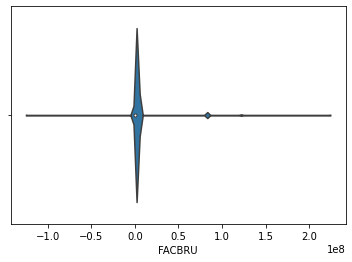

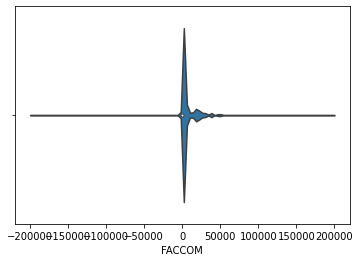

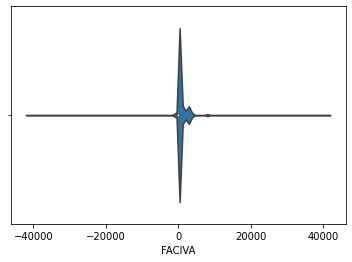

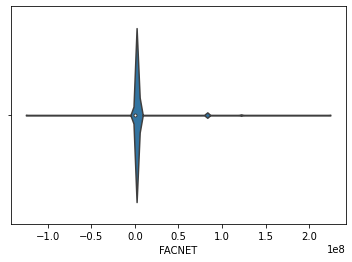

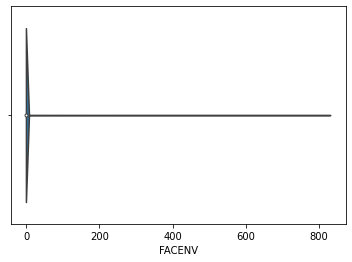

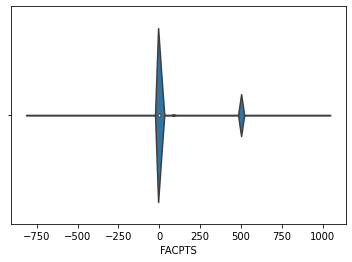

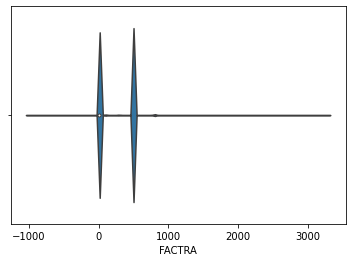

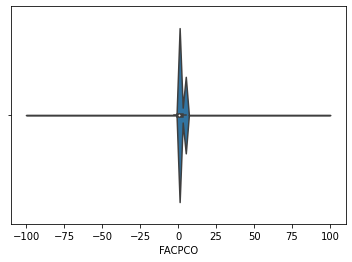

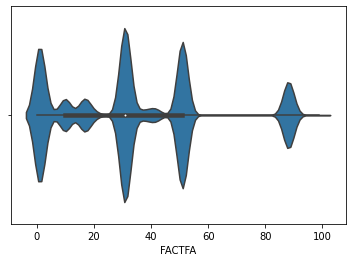

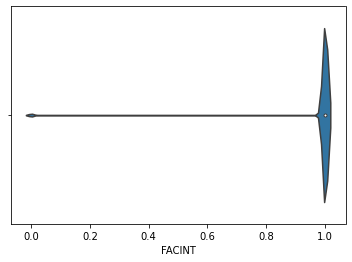

<Figure size 432x288 with 0 Axes>

In [ ]:
for var in var_num:
  sns.violinplot(x=df_sales_clean[var]) 
  plt.figure()

From the graphs shown above, we can see that most of the variables are very focused on only a few values. Only values in column 'FACTFA' vary more.

In [ ]:
for var in var_num:
  df_valuecounts = pd.DataFrame(df_sales_clean[var].value_counts())
  df_valuecounts['percentage'] = pd.DataFrame(df_sales_clean[var].value_counts()/df_sales_clean[var].count())
  print(df_valuecounts.head(10))

Categorical Variables

<Figure size 432x288 with 0 Axes>

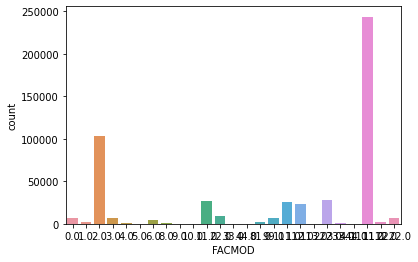

<Figure size 432x288 with 0 Axes>

In [ ]:
# Select columns that are of my interest: Only 1 categorical variable (Payment Type)
var_car = 'FACMOD'

sns.countplot(x=df_sales_clean[var_car])
plt.figure()

In [ ]:
df_valuecounts = pd.DataFrame(df_sales_clean[var_car].value_counts())
df_valuecounts['percentage'] = pd.DataFrame(df_sales_clean[var_car].value_counts()/df_sales_clean[var_car].count())
df_valuecounts.head(10)

,FACMOD,percentage
1111.0,243471,0.486870
2.0,102907,0.205784
222.0,28339,0.056670
11.0,26260,0.052512
111.0,25347,0.050686
112.0,23278,0.046549
22.0,8919,0.017835
3.0,7194,0.014386
0.0,6999,0.013996
99.0,6581,0.013160


#### Data Cleaning & Format Correction

1. Change and correct data format (dtype).
3. Reformat time series variables.

In [ ]:
# Change data format (dtype)

# change dtype to integers
df_sales_clean[['FACCLI','FACMOD']] = df_sales_clean[['FACCLI','FACMOD']].astype(int)

# Reformat time series variables.
df_sales_clean['FACFEC'] = df_sales_clean['FACFEC'].astype(int).astype(str)
df_sales_clean['FACFEC'] = pd.to_datetime(df_sales_clean.FACFEC, yearfirst=True,infer_datetime_format=True,errors='coerce')

In [ ]:
df_sales_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500074 entries, 0 to 500073
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   FACNUM  500074 non-null  object        
 1   FACFEC  500074 non-null  datetime64[ns]
 2   FACBRU  500074 non-null  float64       
 3   FACCOM  500074 non-null  float64       
 4   FACIVA  500074 non-null  float64       
 5   FACNET  500074 non-null  float64       
 6   FACCLI  500074 non-null  int64         
 7   FACENV  500074 non-null  float64       
 8   FACPTS  500074 non-null  float64       
 9   FACTRA  500074 non-null  float64       
 10  FACPCO  500074 non-null  float64       
 11  FACTFA  500074 non-null  float64       
 12  FACINT  500074 non-null  float64       
 13  FACMOD  500074 non-null  int64         
dtypes: datetime64[ns](1), float64(10), int64(2), object(1)
memory usage: 53.4+ MB


Now that both datasets are clean and the format of each column was all corrected. I will combine 2 datasets using an outer join:

### Merged Datasets Overview

In [ ]:
# Double check the unique users in both datasets and cross check which users are not in the other datasets:
client_list1 = df_client_clean['PAGCLI'].unique().tolist()
client_list2 = df_sales_clean['FACCLI'].unique().tolist()

not_in_client_list2 = []
not_in_client_list1 = []

for i in client_list1:
  if i not in client_list2:
    not_in_client_list2.append(i)

for i in client_list2:
  if i not in client_list1:
    not_in_client_list1.append(i)

print(len(not_in_client_list1),len(not_in_client_list2))

2574 1514


!!! IMPORTANT !!! 
From the above output we can see that the numbers of client codes in both datasets don't match very well. This I have to come back to investigate the reason in more detail later. Now I will just do an inner join to simplify the analysis.

In [ ]:
df_all = df_sales_clean.merge(df_client_clean,how='inner',left_on='FACCLI',right_on='PAGCLI')
df_all.drop('PAGCLI',axis=1,inplace=True)
df_all.head()

,FACNUM,FACFEC,FACBRU,FACCOM,FACIVA,FACNET,FACCLI,FACENV,FACPTS,FACTRA,FACPCO,FACTFA,FACINT,FACMOD,PAGLOG,PAGMOD,PAGDIA,PAGGRU,PAGALB,PAGFAC,PAGPOF,PAGPRF,PAGFEC,PAGCOM,PAGFIJ,PAGTRA,PAGVEN,PAGDEU,PAGCIF,PAGPER
0,L500139,2020-10-30,18550.0,0.0,0.00,18550.00,13290,0.0,0.0,0.0,0.0,1.0,1.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1
1,E500047,2020-10-30,682.5,0.0,143.33,825.83,13290,0.0,0.0,0.0,0.0,1.0,0.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1
2,E500018,2016-10-17,741.0,0.0,0.00,741.00,13290,0.0,0.0,0.0,0.0,1.0,1.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1
3,L500026,2016-10-17,20140.0,0.0,0.00,20140.00,13290,0.0,0.0,0.0,0.0,1.0,1.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1
4,E500021,2016-11-25,-741.0,0.0,0.00,-741.00,13290,0.0,0.0,0.0,0.0,1.0,1.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1


In [ ]:
df_all.shape

(380840, 30)

In [ ]:
df_all['FACCLI'].nunique()

4677

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380840 entries, 0 to 380839
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   FACNUM  380840 non-null  object        
 1   FACFEC  380840 non-null  datetime64[ns]
 2   FACBRU  380840 non-null  float64       
 3   FACCOM  380840 non-null  float64       
 4   FACIVA  380840 non-null  float64       
 5   FACNET  380840 non-null  float64       
 6   FACCLI  380840 non-null  int64         
 7   FACENV  380840 non-null  float64       
 8   FACPTS  380840 non-null  float64       
 9   FACTRA  380840 non-null  float64       
 10  FACPCO  380840 non-null  float64       
 11  FACTFA  380840 non-null  float64       
 12  FACINT  380840 non-null  float64       
 13  FACMOD  380840 non-null  int64         
 14  PAGLOG  380840 non-null  int64         
 15  PAGMOD  380840 non-null  int64         
 16  PAGDIA  380840 non-null  int64         
 17  PAGGRU  380840 non-null  int6

Now I have a merged dataset with 4677 unique clients and 380840 billing records.

#### Correlation Matrix

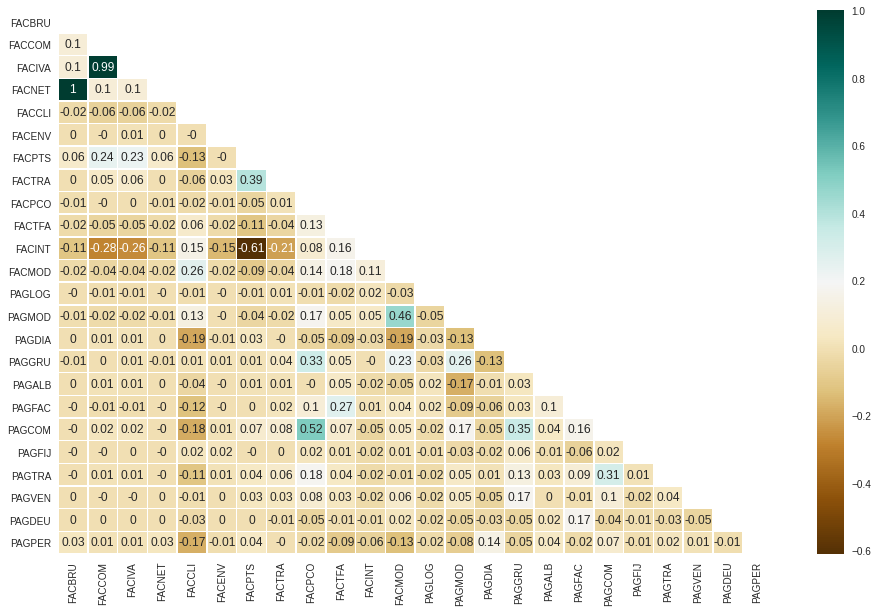

In [ ]:
corr = round(df_all.corr(),2)
corr = corr.mask(np.triu(np.ones(corr.shape)).astype(np.bool))

fig, ax = plt.subplots(figsize=(16,10))

sns.heatmap(corr, annot=True, linewidths=.5,ax=ax, cmap='BrBG')
plt.show()

In [ ]:
# Build clusters according to the degree of correlation and compare it with the K-means result. (Do another K-Means in all variables)
# Run a loop to check which variables are really correlated. This for loop should be run to each variable and the output would be a cluster.
# Accodring to the matrix correlation, I expect low level of colinearity because low degree of correlation between variables.
# When a threshold is between 0.8 - 0.99, high correlation and discard one variables. (TBC)
# Next step is to look for clusters (run the loop for each variables to build vectors)
# As a first approximation we have defined a process of clustering by defining a threshold for well correlated variables.
# If there's enough time, run the same loop to negative correlated variables.

## K-Means Client Segmentation with RFM Variables
RFM Analysis is a technique to create client segments based on the three key purchase-behavior variables: 

1. **Recency** - Time since last purchase. 
In the Data Preparation section, I will create a variable that indicates the duration (in day) since their last purchase.
2. **Frequency** - The frequency of the client transactions or visists. In this case I will create a new variable and calculate the average days between purchases as frequency.
3. **Monetary value** - The intention of client to spend or purchasing power of client. Here I will create 2 variables: One is the total spend per year and the other is the average spend per invoice using the variable 'FACBRU' (nominal value) in the dataset.




### Data Preparation
In this section, I will prepare the dataset in order to further carry out the RFM analysis. The main focus is to create necessary variables for the analysis.

In [ ]:
# Create Billing Year column ('FACYEAR') to better organize and analyze the data
year = pd.DatetimeIndex(df_all['FACFEC']).year
df_all.insert(2, 'FACYEAR', year)
df_all.tail()

,FACNUM,FACFEC,FACYEAR,FACBRU,FACCOM,FACIVA,FACNET,FACCLI,FACENV,FACPTS,FACTRA,FACPCO,FACTFA,FACINT,FACMOD,PAGLOG,PAGMOD,PAGDIA,PAGGRU,PAGALB,PAGFAC,PAGPOF,PAGPRF,PAGFEC,PAGCOM,PAGFIJ,PAGTRA,PAGVEN,PAGDEU,PAGCIF,PAGPER
380835,1019187,2020-12-03,2020,0.0,0.0,1.05,6.05,18457,1.0,5.0,5.0,0.0,30.0,1.0,112,0,111,0,1680,1,1,CORDOBA,CORDOBA,2020-10-05,0.0,0.0,0.0,58,0.0,B56025950,1
380836,1106163,2021-04-01,2021,0.0,0.0,1.05,6.05,18700,1.0,5.0,5.0,0.0,30.0,1.0,1111,0,1111,0,1711,1,1,MARBELLA,MALAGA,2021-02-22,0.0,0.0,0.0,94,0.0,B02658334,1
380837,Q144645,2021-04-21,2021,210.0,2.1,0.44,212.54,18700,0.0,0.0,0.0,1.0,88.0,1.0,1111,0,1111,0,1711,1,1,MARBELLA,MALAGA,2021-02-22,0.0,0.0,0.0,94,0.0,B02658334,1
380838,1108174,2021-04-30,2021,0.0,0.0,1.68,9.68,18811,1.0,8.0,8.0,0.0,30.0,1.0,112,0,111,0,99999,1,1,BARCELONA,BARCELONA,2021-04-26,0.0,0.0,0.0,68,0.0,B67512095,3
380839,Q145044,2021-04-30,2021,440.0,10.0,2.52,454.52,18811,0.0,0.0,0.0,0.0,88.0,1.0,112,0,111,0,99999,1,1,BARCELONA,BARCELONA,2021-04-26,0.0,0.0,0.0,68,0.0,B67512095,3


#### **Invoice Type & Product Type**

Invoices with invoice number starting from an English alphabet are "Special Invoices". When the nominal value of an invoice is negative, it may imply that it's a cancellation invoice or it's a case that Up Spain has to return the money to the clients for a specific reason.

As for the product type of each invoice, as one invoice can only belong to one product, now I will create a new column in the dataset to identify the corresponding product type based on the information given by Up Spain:

Invoice starting number and its corresponding product type:

*   0	Cheque Comida
*   1	Tarjeta Comida
*   2	Tarjeta Transporte
*   5	Cadhoc
*   6	Guardería
*   9	Retriplus

I will create another column that will specify the special invoices so that it's easier for the analysis later.

!!!IMPORTANT!!!
Here I have to confirm with Up Spain if all special invoices shouldn't be included into the calculation. As there are some special invoices do have positive nominal value.

In [ ]:
# Create a function to identify the product type of each invoice.
def proType(x):
  num_list = list(map(str,range(0,10,1)))
  if x[0] == '0' or ((x[0] not in num_list) and (x[1]=='0')):
    return 'Cheque Comida'
  elif x[0] == '1' or ((x[0] not in num_list) and (x[1]=='1')):
    return 'Tarjeta Comida'
  elif x[0] == '2' or ((x[0] not in num_list) and (x[1]=='2')):
    return 'Tarjeta Transporte'
  elif x[0] == '5' or ((x[0] not in num_list) and (x[1]=='5')):
    return 'Cadhoc'
  elif x[0] == '6' or ((x[0] not in num_list) and (x[1]=='6')):
    return 'Guardería'
  elif x[0] == '9' or ((x[0] not in num_list) and (x[1]=='9')):
    return 'Retriplus'
  else:
    return 'Others' 


# Create a function to specify special invoices.
def special(x):
  num_list = list(map(str,range(0,10,1)))
  if x[0] not in num_list:
    return 1
  else:
    return 0

In [ ]:
# Apply the function to the dataframe so that we have a new column that indicates the product type per invoice
productType = df_all['FACNUM'].apply(proType)
specialInvoice = df_all['FACNUM'].apply(special)
df_all.insert(0,'ProductType',productType)
df_all.insert(2,'SpecialInvoice',specialInvoice)

In [ ]:
df_all.head()

,ProductType,FACNUM,SpecialInvoice,FACFEC,FACYEAR,FACBRU,FACCOM,FACIVA,FACNET,FACCLI,FACENV,FACPTS,FACTRA,FACPCO,FACTFA,FACINT,FACMOD,PAGLOG,PAGMOD,PAGDIA,PAGGRU,PAGALB,PAGFAC,PAGPOF,PAGPRF,PAGFEC,PAGCOM,PAGFIJ,PAGTRA,PAGVEN,PAGDEU,PAGCIF,PAGPER
0,Cadhoc,L500139,1,2020-10-30,2020,18550.0,0.0,0.00,18550.00,13290,0.0,0.0,0.0,0.0,1.0,1.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1
1,Cadhoc,E500047,1,2020-10-30,2020,682.5,0.0,143.33,825.83,13290,0.0,0.0,0.0,0.0,1.0,0.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1
2,Cadhoc,E500018,1,2016-10-17,2016,741.0,0.0,0.00,741.00,13290,0.0,0.0,0.0,0.0,1.0,1.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1
3,Cadhoc,L500026,1,2016-10-17,2016,20140.0,0.0,0.00,20140.00,13290,0.0,0.0,0.0,0.0,1.0,1.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1
4,Cadhoc,E500021,1,2016-11-25,2016,-741.0,0.0,0.00,-741.00,13290,0.0,0.0,0.0,0.0,1.0,1.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1


#### **Recency**

In order to create a variable that indicates the duration (in day) since their last purchase, I have to find out the last purchase date of each client and calculate the difference of today (May 12, 2021).

Be careful! Here I'm only interested in the standard invoices (rather than the special invoices.) So I should only take the last "standard invoice" date to calculate the Recency.

In [ ]:
df_lastpurchase = df_all[['FACCLI','FACFEC']][df_all['SpecialInvoice']==0].sort_values('FACFEC').drop_duplicates(subset=['FACCLI'], keep='last', inplace=False)
df_lastpurchase.columns = ['FACCLI','LastPurchaseDate']

today = pd.to_datetime('today').normalize()

df_lastpurchase['Recency'] = abs((df_lastpurchase['LastPurchaseDate'] - today).dt.days)

df_all = df_all.merge(df_lastpurchase, how='left',on=['FACCLI'])
df_all.head()

,ProductType,FACNUM,SpecialInvoice,FACFEC,FACYEAR,FACBRU,FACCOM,FACIVA,FACNET,FACCLI,FACENV,FACPTS,FACTRA,FACPCO,FACTFA,FACINT,FACMOD,PAGLOG,PAGMOD,PAGDIA,PAGGRU,PAGALB,PAGFAC,PAGPOF,PAGPRF,PAGFEC,PAGCOM,PAGFIJ,PAGTRA,PAGVEN,PAGDEU,PAGCIF,PAGPER,LastPurchaseDate,Recency
0,Cadhoc,L500139,1,2020-10-30,2020,18550.0,0.0,0.00,18550.00,13290,0.0,0.0,0.0,0.0,1.0,1.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1,2021-05-01,13.0
1,Cadhoc,E500047,1,2020-10-30,2020,682.5,0.0,143.33,825.83,13290,0.0,0.0,0.0,0.0,1.0,0.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1,2021-05-01,13.0
2,Cadhoc,E500018,1,2016-10-17,2016,741.0,0.0,0.00,741.00,13290,0.0,0.0,0.0,0.0,1.0,1.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1,2021-05-01,13.0
3,Cadhoc,L500026,1,2016-10-17,2016,20140.0,0.0,0.00,20140.00,13290,0.0,0.0,0.0,0.0,1.0,1.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1,2021-05-01,13.0
4,Cadhoc,E500021,1,2016-11-25,2016,-741.0,0.0,0.00,-741.00,13290,0.0,0.0,0.0,0.0,1.0,1.0,1111,0,1111,0,507,1,1,ALCOBENDAS,MADRID,2019-12-30,0.0,0.0,0.0,86,0.0,B82378431,1,2021-05-01,13.0


#### **Frequency**
The frequency of the client transactions or visists. In this case I will create a new variable and calculate the average days between invoice dates as frequency.

Note:
1. If several invoices are issued at the same day from a client, I remove duplicates and only leave 1 date to indicate the purchase date. So the result of the average purchase frequency is more accurate and objective.

2. Same as Recency variable, here I'm only interested in the standard invoices (rather than the special invoices.) So I should only take the last "standard invoice" date to calculate the Recency.

In [ ]:
df_frequency = df_all[['FACCLI','FACFEC']][df_all['SpecialInvoice']==0].sort_values(['FACCLI','FACFEC'])

# If several invoices are issued at the same day, I only want to count them as 1 Purchase:
def func(df):
  for i in df['FACCLI'].unique():
    df[df['FACCLI']==i] = df[df['FACCLI']==i].drop_duplicates('FACFEC')
  return df

df_frequency = func(df_frequency)

df_frequency['LastInvoiceDate'] = df_frequency.groupby('FACCLI')['FACFEC'].shift()
df_frequency['Frequency'] = (df_frequency['FACFEC'] - df_frequency['LastInvoiceDate']).dt.days
df_frequency = df_frequency[['FACCLI','Frequency']].groupby('FACCLI',as_index=False).mean().round(2)

df_all = df_all.merge(df_frequency, how='left',on='FACCLI')

#### **Monetary Value**

The Monetary Value is the intention of the clients to spend or purchasing power of the clients. Instead of Nominal Value, I will create 2 variables: 

1. Annual Income of a client.
2. The average income per invoice of a client.

Note:
1. Invoice Income = Total Sales (column 'FACNET') - Nominal Value (column 'FACBRU') - IVA ('FACIVA')
2. Average Annual Income of a client: I will only take into account the sales from year 2018-2020 because 2021 hasn't ended and so that the result could reflect more the recent reality. 
3. The Invoice Income of a client: I will only take into account the sales from year 2018, so the result could reflect more the recent reality. 



In [ ]:
# Average Annual Income of a client
df_mvalue = df_all[['FACCLI','FACYEAR','FACNUM','FACNET','FACBRU','FACIVA']][(df_all['FACYEAR']>=2018) & (df_all['FACYEAR']<2021)].copy()
df_mvalue['Avg.AnualIncome'] = (df_mvalue['FACNET'] - df_mvalue['FACBRU'] - df_mvalue['FACIVA']).round(2)
df_mvalue = df_mvalue[['FACCLI','FACYEAR','Avg.AnualIncome']].groupby(['FACCLI','FACYEAR'],as_index=False).sum().groupby('FACCLI', as_index=False).mean().round(2).drop('FACYEAR',axis=1)

# Average Income per Invoice of a client
df_mvalue1 = df_all[['FACCLI','FACYEAR','FACNUM','FACNET','FACBRU','FACIVA']][df_all['FACYEAR']>=2018].copy()
df_mvalue1['Income'] = (df_mvalue1['FACNET'] - df_mvalue1['FACBRU'] - df_mvalue1['FACIVA']).round(2)

df_mvalue2 = df_mvalue1.groupby('FACCLI',as_index=False).sum()[['FACCLI','Income']]
df_mvalue2['TotalInvoice'] = df_mvalue1.groupby('FACCLI',as_index=False).count()['FACNUM']
df_mvalue2['Avg.InvoiceIncome'] = (df_mvalue2['Income']/df_mvalue2['TotalInvoice']).round(2)
df_mvalue2.drop(['Income','TotalInvoice'],axis=1,inplace=True)

# Merge these 2 variables with the df_all dataframe
df_all = df_all.merge(df_mvalue,how='left',on='FACCLI').merge(df_mvalue2, how='left',on='FACCLI')


Now that we have the variables in order to carry out the RFM analysis.

In [ ]:
df_rfm = df_all[['FACCLI','Recency','Frequency','Avg.AnualIncome','Avg.InvoiceIncome']].drop_duplicates('FACCLI').sort_values('FACCLI').reset_index(drop=True)
df_rfm.head()

,FACCLI,Recency,Frequency,Avg.AnualIncome,Avg.InvoiceIncome
0,1,18.0,35.71,473.48,14.64
1,3,934.0,150.22,0.00,0.00
2,8,531.0,36.52,57.50,2.61
3,14,491.0,30.99,1055.08,33.67
4,32,13.0,40.02,858.08,40.11


In [ ]:
df_rfm.describe()

,FACCLI,Recency,Frequency,Avg.AnualIncome,Avg.InvoiceIncome
count,4677.000000,4571.000000,4279.000000,2855.000000,2885.000000
mean,12181.748343,1093.937432,64.612388,362.205566,22.188887
std,7281.818186,1247.458188,108.763447,783.729136,29.652596
min,1.000000,4.000000,1.000000,-2.720000,-2.720000
25%,7763.000000,28.000000,24.595000,29.395000,2.830000
50%,11648.000000,480.000000,32.860000,138.150000,11.300000
75%,16070.000000,2289.500000,66.220000,389.010000,29.090000
max,80001.000000,8156.000000,2527.670000,15227.750000,305.360000


#### Visualize the Variables

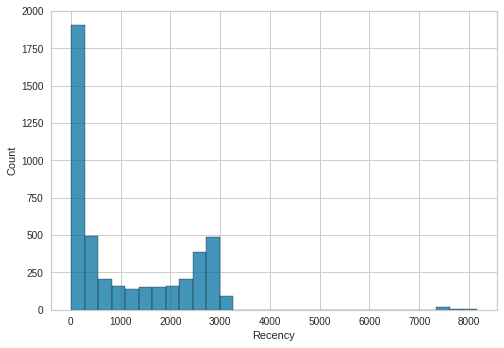

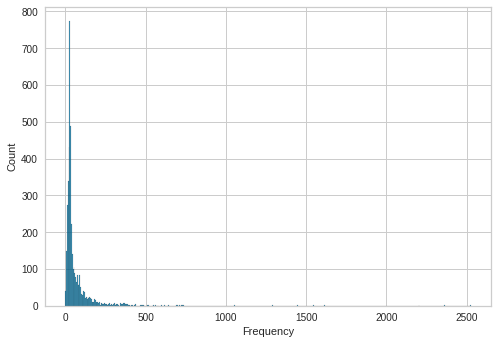

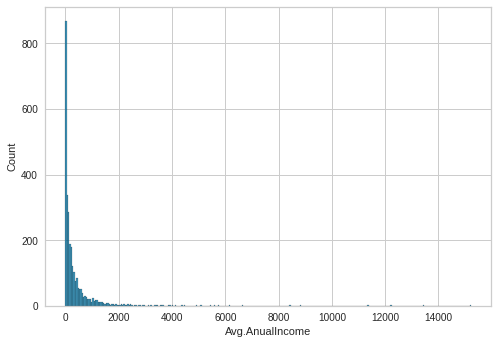

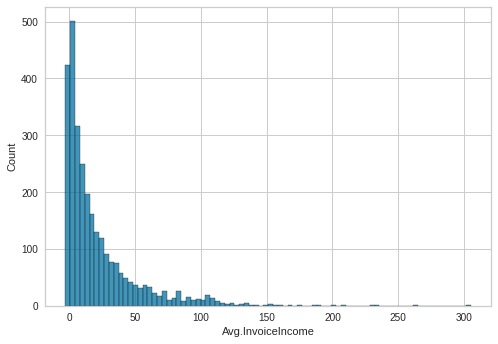

<Figure size 576x396 with 0 Axes>

In [ ]:
for i in df_rfm.columns[1:]:
  sns.histplot(x = df_rfm[i])
  plt.figure()

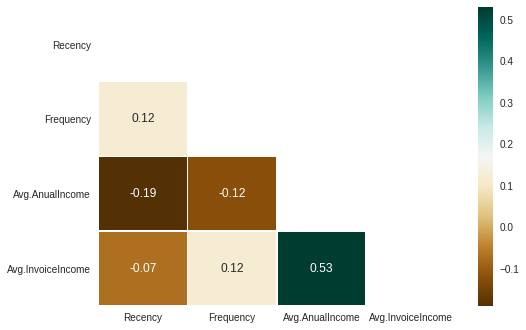

In [ ]:
corr = round(df_rfm.iloc[:,1:5].corr(),2)
corr = corr.mask(np.triu(np.ones(corr.shape)).astype(np.bool))

fig, ax = plt.subplots()

sns.heatmap(corr, annot=True, linewidths=.5,ax=ax, cmap='BrBG')
plt.show()

### Client Segmentation
!!!IMPORTANT!!!

This part I should confirm with Up Spain if the segmentations make sense and if I should adjust relative importance/weights of each variables to get the RFM Score. (Maybe types of product would have impact on the weights.)

Now the dataset df_rfm is ready for me create clients segmentations based on these variables.

I will assign score from 1 to 4 (4 is more preferable) in each rfm variable using quantiles, then create client segmentations based on the following criteria:

1. **Key Clients:** High Recency(4), High frequency(4), High Monetary Value(4)
2. **Loyal Clients:** High frequency(4)
3. **Lost Clients:** Low Recency(1)
4. **High Value Clients:** High Monetary Value(4)

In [ ]:
df_rfm.head()

,FACCLI,Recency,Frequency,Avg.AnualIncome,Avg.InvoiceIncome
0,1,18.0,35.71,473.48,14.64
1,3,934.0,150.22,0.00,0.00
2,8,531.0,36.52,57.50,2.61
3,14,491.0,30.99,1055.08,33.67
4,32,13.0,40.02,858.08,40.11


In [ ]:
quantiles = df_rfm.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Avg.AnualIncome': {0.25: 29.395, 0.5: 138.15, 0.75: 389.01},
 'Avg.InvoiceIncome': {0.25: 2.83, 0.5: 11.3, 0.75: 29.09},
 'FACCLI': {0.25: 7763.0, 0.5: 11648.0, 0.75: 16070.0},
 'Frequency': {0.25: 24.595, 0.5: 32.86, 0.75: 66.22},
 'Recency': {0.25: 28.0, 0.5: 480.0, 0.75: 2289.5}}

In [ ]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [ ]:
df_rfm_score = df_rfm.copy()
df_rfm_score['R_Score'] = df_rfm_score['Recency'].apply(RScore, args=('Recency',quantiles))
df_rfm_score['F_Score'] = df_rfm_score['Frequency'].apply(RScore, args=('Frequency',quantiles))
df_rfm_score['M_Score'] = df_rfm_score['Avg.AnualIncome'].apply(FMScore, args=('Avg.AnualIncome',quantiles))
df_rfm_score['RFM_Score'] = df_rfm_score['R_Score'] + df_rfm_score['F_Score'] + df_rfm_score['M_Score']
df_rfm_score.head(10)

,FACCLI,Recency,Frequency,Avg.AnualIncome,Avg.InvoiceIncome,R_Score,F_Score,M_Score,RFM_Score
0,1,18.0,35.71,473.48,14.64,4,2,4,10
1,3,934.0,150.22,0.00,0.00,2,1,1,4
2,8,531.0,36.52,57.50,2.61,2,2,2,6
3,14,491.0,30.99,1055.08,33.67,2,3,4,9
4,32,13.0,40.02,858.08,40.11,4,2,4,10
5,50,7469.0,27.48,NaN,NaN,1,3,4,8
6,58,2447.0,107.52,NaN,NaN,1,1,4,6
7,68,10.0,60.46,367.21,12.65,4,2,3,9
8,88,57.0,65.48,199.10,17.85,3,2,3,8
9,96,2782.0,135.89,NaN,NaN,1,1,4,6


Now that I have the score for each variable, I can check how many clients are in each segments I defined:
1. **Key Clients:** High Recency(4), High frequency(4), High Monetary Value(4)
2. **Loyal Clients:** High frequency(4)
3. **Lost Clients:** Low Recency(1)
4. **High Value Clients:** High Monetary Value(4)

In [ ]:
print("Key Clients:",len(df_rfm_score[(df_rfm_score['R_Score']==4) & (df_rfm_score['F_Score']==4)&(df_rfm_score['M_Score']==4)]))
print('Loyal Clients: ',len(df_rfm_score[df_rfm_score['F_Score']==4]))
print("Lost Clients:",len(df_rfm_score[df_rfm_score['R_Score']==1]))
print('High Value Cliets:', len(df_rfm_score[df_rfm_score['M_Score']==4]))

Key Clients: 294
Loyal Clients:  1070
Lost Clients: 1249
High Value Cliets: 2536


In [ ]:
df_rfm_score['RFM_Score'].unique()
df_rfm_score.groupby('RFM_Score',as_index=False).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Avg.AnualIncome': 'mean'}).sort_values('RFM_Score',ascending=False).round(2)

,RFM_Score,Recency,Frequency,Avg.AnualIncome
9,12,14.09,15.57,1483.87
8,11,48.15,20.70,664.42
7,10,300.28,25.29,448.33
6,9,976.71,28.65,258.43
5,8,1355.97,37.41,154.82
4,7,1331.61,86.16,102.06
3,6,1912.51,126.30,60.02
2,5,622.39,150.44,32.50
1,4,917.20,301.23,11.32
0,3,7807.00,131.00,2.73


### K-Means Clustering with RFM Variables



In [ ]:
df_rfm.head()
df_rfm.columns

Index(['FACCLI', 'Recency', 'Frequency', 'Avg.AnualIncome',
       'Avg.InvoiceIncome'],
      dtype='object')

Before running K-Means, it's important to normalize the data.

In [ ]:
# Data Normalization
scaler = StandardScaler()

df_rfm_standard = pd.DataFrame(scaler.fit_transform(df_rfm.dropna(axis=0)),columns=['FACCLI', 'Recency', 'Frequency', 'Avg.AnualIncome','Avg.InvoiceIncome'])
df_rfm_standard.iloc[:,1:].describe()

,Recency,Frequency,Avg.AnualIncome,Avg.InvoiceIncome
count,2.782000e+03,2.782000e+03,2.782000e+03,2.782000e+03
mean,1.225156e-17,-1.403143e-16,6.070909e-16,1.035955e-15
std,1.000180e+00,1.000180e+00,1.000180e+00,1.000180e+00
min,-6.732386e-01,-5.359596e-01,-4.725299e-01,-8.544364e-01
25%,-6.396282e-01,-3.350462e-01,-4.255559e-01,-6.551820e-01
50%,-5.780091e-01,-2.453718e-01,-2.873242e-01,-3.659957e-01
75%,5.507395e-01,-2.779692e-02,4.291171e-02,2.420478e-01
max,2.118191e+01,2.411882e+01,1.876480e+01,9.445278e+00


In [ ]:
df_rfm_standard.columns

Index(['FACCLI', 'Recency', 'Frequency', 'Avg.AnualIncome',
       'Avg.InvoiceIncome'],
      dtype='object')

Segmenting with K-Means, Identify the optimal k.

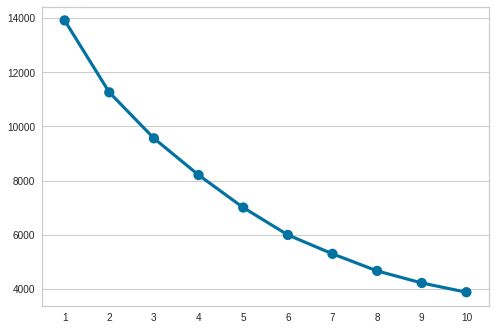

In [ ]:
# SSE = Error Sum of Squares
SSE = []

for k in range(0,10):
  kmeans=KMeans(n_clusters=k+1,random_state=1200).fit(df_rfm_standard)
  SSE.append(kmeans.inertia_)

sns.pointplot(x=list(range(1,11)),y=SSE)
plt.show()

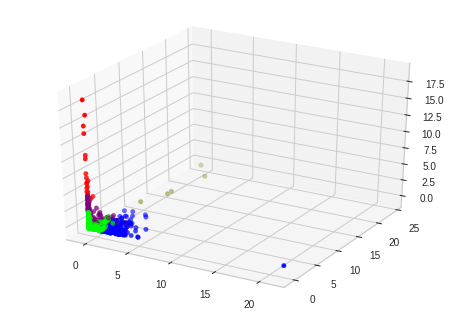

In [ ]:
model = KMeans(n_clusters=5,random_state=1200).fit(df_rfm_standard)
centers=model.cluster_centers_
fig=plt.figure()

ax=fig.add_subplot(projection='3d')
ax.scatter(df_rfm_standard['Recency'],df_rfm_standard['Frequency'],df_rfm_standard['Avg.AnualIncome'],cmap='brg',c=model.predict(df_rfm_standard))
ax.scatter(centers[:,0],centers[:,1],c='black');

# Add rotation
# Add names of the variables
# Remove outliers